# Replication of results for the COVID19 model

This is a notebook to recreate the results of Section 8 of

W.N. Edeling, "On the deep active subspace method", SIAM/ASA Journal on Uncertainty Quantification, 2022.

Here we will apply the deep active subspace method[1] to CovidSim, which is an individual-based simulation code developed by the MRC Centre for Global Infectious Disease Analysis at Imperial College London [2]. We selected 51 continuous input parameters, see the article above for more information.


### Requirements

The Deep Active Subspace method is implemented in [EasySurrogate](https://github.com/wedeling/EasySurrogate). To install, simply uncomment the `!pip install` line below (or clone it from GitHub). Furthermore, `chaospy` (see pip command), and the standard `scipy`, `seaborn` and `pandas` libraries are also required.

[1] Tripathy, R., & Bilionis, I. (2019, August). Deep active subspaces: A scalable method for high-dimensional uncertainty propagation. In International Design Engineering Technical Conferences and Computers and Information in Engineering Conference (Vol. 59179, p. V001T02A074). American Society of Mechanical Engineers.

[2] Ferguson, N., Laydon, D., Nedjati Gilani, G., Imai, N., Ainslie, K., Baguelin, M., ... & Ghani, A. (2020). Report 9: Impact of non-pharmaceutical interventions (NPIs) to reduce COVID19 mortality and healthcare demand.

In [1]:
#!pip install easysurrogate==0.18
#!pip install chaospy

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import easysurrogate as es
from matplotlib import gridspec
import seaborn as sns
from scipy import linalg
# this contains the EasyVVUQ 'vary' distionary with the parameter names and input distributions
from vary import *

In [3]:
# select the seismic color scheme
plt.rcParams['image.cmap'] = 'seismic'

### EasySurrogate campaign
EasySurrogate's basic object is called a `campaign', which handles the data.

In [4]:
# Create EasySurrogate campaign
campaign = es.Campaign()

### Load training data

Here we use the campaign to load the training data, which is precomputed and stored in the `covidsim_samples_only_cont.hdf5` file. These 3000 Monte Carlo samples were computed on the Eagle supercomputer at the Poznan Supercomputing and Networking Center, using 50 nodes and 28 cores per node.

In [5]:
# training data
data = campaign.load_hdf5_data(file_path='covidsim_samples_only_cont.hdf5')
params = data['params']
samples = data['samples']

# size input domain
D = params.shape[1]

# normalize inputs to [-1, 1]
p_min = np.array([vary[param].lower[0] for param in vary.keys()])
p_max = np.array([vary[param].upper[0] for param in vary.keys()])
params = (params - 0.5 * (p_min + p_max)) / (0.5 * (p_max - p_min))

# select (scalar) QoI
samples = samples[:, -1].reshape([-1, 1])
n_out = samples.shape[1]

# compute the gradient of f and not of ||f||_2.
norm = False

Loaded params
Loaded samples


### Train an unconstrained artificial neural network

We first train a vanilla artificial neural network without a DAS layer. The inputs are already normalized to lie within $[-1, 1]$, and we standardize the output. We set `test_frac = 0.5` to reserve 50\% of the 3000 samples as validation data in the contour plots below.

In [6]:
ann_surrogate = es.methods.ANN_Surrogate()
ann_surrogate.train(params, samples, 
                n_iter=10000, n_layers=4, n_neurons=10, test_frac = 0.5, 
                batch_size = 64, lamb=0.0, standardize_X=False, standardize_y=True)
ann_analysis = es.analysis.ANN_analysis(ann_surrogate)

Creating ANN_Surrogate Object
Creating Feature Engineering object
Using  1500/3000 samples to train the ML model
done preparing data
Neural net parameters
Number of layers = 4
Number of features = 51
Loss function = squared
Number of neurons per hidden layer = 10
Number of output neurons = 1
Activation = ['linear', 'tanh', 'tanh', 'tanh', 'linear']
This neural network has 751 weights.
Training Artificial Neural Network...
Batch 0 learning rate 0.001 loss: 0.8328866133326657
Batch 1000 learning rate 0.001 loss: 0.031813007334293236
Batch 2000 learning rate 0.001 loss: 0.041795424983934876
Batch 3000 learning rate 0.001 loss: 0.02513003870794843
Batch 4000 learning rate 0.001 loss: 0.027413616559021654
Batch 5000 learning rate 0.001 loss: 0.015549329523534874
Batch 6000 learning rate 0.001 loss: 0.01647677011685394
Batch 7000 learning rate 0.001 loss: 0.016798345130473537
Batch 8000 learning rate 0.001 loss: 0.014180540568168825
Batch 9000 learning rate 0.001 loss: 0.021787801972784807
C

### Select $d$

We we select $d=2$, i.e. we are constructing a 2D active subspace.

In [7]:
########################################
# choose the active subspace dimension #
########################################
d = 2

### Train a deep active subspace network

Below we train a deep active subspace network, using $d=1$ in the DAS layer.

In [8]:
#####################
# train DAS network #
#####################

das_surrogate = es.methods.DAS_Surrogate()
das_surrogate.train(params, samples, d, n_iter=10000, n_layers=4, n_neurons=10, test_frac = 0.5, 
                batch_size = 64, standardize_X=False, standardize_y=True)
# a dict containing some dimenions of the DAS network
dims = das_surrogate.get_dimensions()
# analysis object, used for sensitivity analysis below
das_analysis = es.analysis.DAS_analysis(das_surrogate)

Creating DAS_Surrogate Object
Creating Feature Engineering object
Using  1500/3000 samples to train the ML model
done preparing data
Neural net parameters
Number of layers = 4
Number of features = 51
Loss function = squared
Number of neurons per hidden layer = 10
Number of output neurons = 1
Activation = ['linear', 'tanh', 'tanh', 'tanh', 'linear']
This neural network has 253 weights.
Training Deep Active Subspace Neural Network...
Batch 0 learning rate 0.001 loss: 3.1401000192067055
Batch 1000 learning rate 0.001 loss: 0.10131829568328085
Batch 2000 learning rate 0.001 loss: 0.04887563714200621
Batch 3000 learning rate 0.001 loss: 0.035740960504328984
Batch 4000 learning rate 0.001 loss: 0.04213588550722447
Batch 5000 learning rate 0.001 loss: 0.05176244903218829
Batch 6000 learning rate 0.001 loss: 0.038186854134728915
Batch 7000 learning rate 0.001 loss: 0.045420083293724836
Batch 8000 learning rate 0.001 loss: 0.04850869067826508
Batch 9000 learning rate 0.001 loss: 0.0360973438641

### Compute the original active subspace of the DAS network

In [9]:
# the gradient matrix computed of the DAS network, computed using the classical AS method
C_das = 0.0
# the MC approximation of C_1 = (df/dh)(df/dh)^T
C_1 = 0.0

n_mc = dims['n_samples']

# Compute C1 and C_das
das_samples = np.zeros(n_mc)
for i, param in enumerate(params):
    # compute the derivative of f at the input layer (needed for C_das)
    df_dx = das_surrogate.derivative(param, norm=False)
    # store predictions for later
    das_samples[i] = das_surrogate.predict(param)
    # derivative of f in the DAS layer (needed for C_1)
    df_dh = das_surrogate.neural_net.layers[1].delta_hy.reshape([-1,1])
    # update C_1 and C_das
    C_1 += np.dot(df_dh, df_dh.T) / n_mc
    C_das += np.dot(df_dx, df_dx.T) / n_mc

# solve eigenvalue problem for C_das
eigvals_C_das, V = linalg.eigh(C_das)

# Sort the eigensolutions in the descending order of eigenvalues
order = eigvals_C_das.argsort()[::-1]
eigvals_C_das = eigvals_C_das[order]
V = V[:, order]
V_1 = V[:, 0:d]

# the DAS weight matrix of the first hidden layer
W_1 = das_surrogate.neural_net.layers[1].W

print("The subspace angles between V1 and W1 are %s" % linalg.subspace_angles(V_1, W_1))

y_das = np.dot(W_1.T, params.T).T

# compute eigenvalues / vectors of C_1 and sort
eigvals_C_1, eigvecs_C_1 = linalg.eigh(C_1)
order = eigvals_C_1.argsort()[::-1]
eigvals_C_1 = eigvals_C_1[order]
eigvecs_C_1 = eigvecs_C_1[:, order]

The subspace angles between V1 and W1 are [4.67857552e-15 1.02230656e-15]


### Recreate the eigenvalue plot

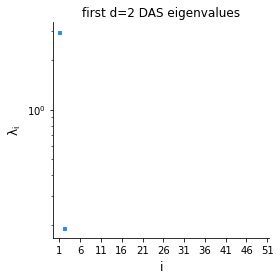

In [10]:
####################
# plot eigenvalues #
####################

fig = plt.figure(figsize=[4, 4])
#
ax = fig.add_subplot(111, title=r'first d=%d DAS eigenvalues' % d, xlim=[-0.5, 51.5], yscale='log')
ax.set_ylabel(r'$\lambda_i$', fontsize=12)
ax.set_xlabel(r'$i$', fontsize=12)
# ax.plot(range(1, d + 1), eigvals_C_1, 'o', color='salmon', markersize=8, 
#          label = '%s of %s' % (r'$\lambda_i$', r'$\overline{C}_1$'))
ax.plot(range(1, d + 1), eigvals_C_das[0:d], 's', color='dodgerblue', markersize=3,
         label='%s of %s' % (r'$\lambda_i$', r'$\overline{C}_{DAS}$'))
ax.set_xticks(np.arange(1, D + 1, 5))
sns.despine(top=True)
# plt.legend(loc=0, frameon=False)
plt.tight_layout()

### Recreate the active subspace plot

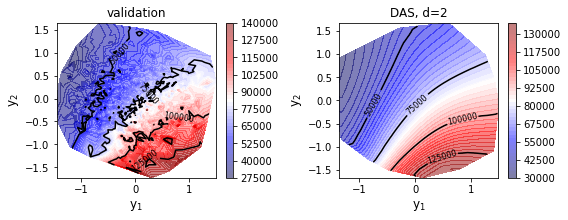

In [11]:
    n_train = dims['n_train']
    fig = plt.figure(figsize=[8, 3.16])
    ax = fig.add_subplot(121, title='validation')
    ax.set_xlabel(r'$y_1$', fontsize=12)
    ax.set_ylabel(r'$y_2$', fontsize=12)
    contours = ax.tricontour(y_das[n_train:, 0], y_das[n_train:, 1], samples[n_train:].flatten(),
                             4, colors='black')
    plt.clabel(contours, inline=True, fontsize=8, manual=False)
    ct = ax.tricontourf(y_das[n_train:, 0], y_das[n_train:, 1], samples[n_train:].flatten(),
                        50, origin='lower', cmap='seismic', alpha=0.5)
    plt.colorbar(ct)

    ax = fig.add_subplot(122, title='DAS, d=%d' %d)
    ax.set_xlabel(r'$y_1$', fontsize=12)
    ax.set_ylabel(r'$y_2$', fontsize=12)
    contours = ax.tricontour(y_das[0:n_train, 0], y_das[0:n_train, 1], das_samples[0:n_train].flatten(),
                             4, colors='black')
    plt.clabel(contours, inline=True, fontsize=8)
    ct = ax.tricontourf(y_das[0:n_train, 0], y_das[0:n_train, 1], das_samples[0:n_train].flatten(),
                        50, origin='lower', cmap='seismic', alpha=0.5)
    plt.colorbar(ct)

    plt.tight_layout()

### Error analysis

The errors were computed using 100 replica networks, which takes a long time (several hours). The errors are therefore loaded from memory using the file `errors_n_neurons10.hdf5`, corresponding to the case of 10 neurons per hidden layer.

If you still wish to recompute the errors, execute `recompute_COVID_errors.py`. Note that it is possible that (1 or 2) outliers are present, where one of the replica neural networks did not converge. We removed these from the HDF5 files.

In [12]:
def get_error_CI(err):
    mean_err = np.mean(err, axis=0)
    lower, upper = analysis.get_confidence_intervals(err, conf=conf)
    err = np.array([mean_err - lower, upper - mean_err])

    return mean_err, err

Loaded err_ANN
Loaded err_ANN_unconstrained
Loaded err_DAS


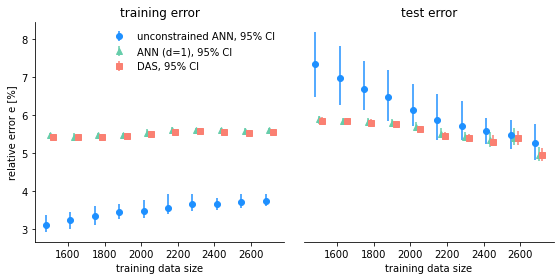

In [13]:
# number of neurons, replicas and tra
n_test_fracs = 10

test_fracs = np.linspace(0.5, 0.1, n_test_fracs)

file = 'errors_n_neurons10.hdf5'

errors = campaign.load_hdf5_data(file_path=file)
err_ANN_unconstrained = errors['err_ANN_unconstrained']
err_ANN = errors['err_ANN']
err_DAS = errors['err_DAS']

# trun into percentage
err_ANN *= 100
err_DAS *= 100
err_ANN_unconstrained *= 100
# select confidence
conf = 0.95
# size of training data used
data_size = (1 - test_fracs) * samples.shape[0]
# mean and CI of ANN training error
analysis = es.analysis.BaseAnalysis()

mean_ANN_err_training, err_ANN_training = get_error_CI(err_ANN[:,:,0])
mean_DAS_err_training, err_DAS_training = get_error_CI(err_DAS[:,:,0])
mean_ANN_unconstrained_training, err_ANN_unconstrained_training = get_error_CI(err_ANN_unconstrained[:,:,0])

mean_ANN_err_test, err_ANN_test = get_error_CI(err_ANN[:,:,1])
mean_DAS_err_test, err_DAS_test = get_error_CI(err_DAS[:,:,1])
mean_ANN_unconstrained_test, err_ANN_unconstrained_test = get_error_CI(err_ANN_unconstrained[:,:,1])

# plot results
import seaborn as sns
fig = plt.figure(figsize=[8, 4])
ax = fig.add_subplot(121)
ax.set_xlabel('training data size')
ax.set_ylabel('relative error e [%]')
ax.set_title('training error')
sns.despine(top=True)
offset = 20

# make the CI plots
ax.errorbar(data_size-offset, mean_ANN_unconstrained_training, 
           yerr=err_ANN_unconstrained_training, fmt='o', color='dodgerblue', label='unconstrained ANN, 95% CI')
ax.errorbar(data_size, mean_ANN_err_training, yerr=err_ANN_training, fmt='^', 
           color='mediumaquamarine', label='ANN (d=1), 95% CI')
ax.errorbar(data_size+offset, mean_DAS_err_training, yerr=err_DAS_training, fmt='s', 
           color='salmon', label='DAS, 95% CI')

# make the plot using all samples, not with confidence intervals
# ax.plot(data_size-offset, mean_ANN_unconstrained_training, 'o', color='dodgerblue',
#         label='unconstrained ANN, 95% CI')
# ax.plot(data_size-offset, err_ANN_unconstrained[:,:,0].T, '.', color='dodgerblue')

# ax.plot(data_size, mean_ANN_err_training, '^', color='mediumaquamarine',
#         label='ANN (d=1), 95% CI')
# ax.plot(data_size, err_ANN[:,:,0].T, '.', color='mediumaquamarine')

# ax.plot(data_size+offset, mean_DAS_err_training, 's', color='salmon', label='DAS, 95% CI')
# ax.plot(data_size+offset, err_DAS[:,:,0].T, '.', color='salmon')

leg = ax.legend(loc=0, frameon=False)
#
ax2 = fig.add_subplot(122, sharey=ax)
ax2.set_xlabel('training data size')
ax2.set_title('test error')

# make the CI plots
ax2.errorbar(data_size, mean_ANN_err_test, yerr=err_ANN_test, fmt='^', color='mediumaquamarine')
ax2.errorbar(data_size+offset, mean_DAS_err_test, yerr=err_DAS_test, fmt='s', color='salmon')
ax2.errorbar(data_size-offset, mean_ANN_unconstrained_test, yerr=err_ANN_unconstrained_test,
            fmt='o', color='dodgerblue')

# make the plot using all samples, not with confidence intervals
# ax2.plot(data_size, mean_ANN_err_test, '^', color='mediumaquamarine')
# ax2.plot(data_size, err_ANN[:,:,1].T, '.', color='mediumaquamarine')

# ax2.plot(data_size+offset, mean_DAS_err_test, 's', color='salmon')
# ax2.plot(data_size+offset, err_DAS[:,:,1].T, '.', color='salmon')

# ax2.plot(data_size-offset, mean_ANN_unconstrained_test, 'o', color='dodgerblue')
# ax2.plot(data_size-offset, err_ANN_unconstrained[:,:,1].T, '.', color='dodgerblue')

sns.despine(left=True, ax=ax2)
ax2.get_yaxis().set_visible(False)
plt.tight_layout()


### Gobal derivative-based sensitivity plots (not in article)

In [14]:
def sensitivity(idx, V_i, **kwargs):
    fig = plt.figure(figsize=[10, 10])
    ax = fig.add_subplot(111, title=kwargs.get('title', ''))
    ax.set_xlabel(r'$\nu_i$', fontsize=14)    
    ax.barh(range(V_i.size), width = V_i[idx].flatten(), color = 'dodgerblue')
    ax.set_yticks(range(V_i.size))
    ax.set_yticklabels(param_names[idx[0]], fontsize=11)
    ax.invert_yaxis()
    sns.despine(top=True)
    plt.tight_layout()

Parameters ordered from most to least important:
[[16  9 12 11  4 31 10  1 21  6 20  8 36 30 50 32 18  5 23 33 13  7 45  3
   0 37 42 14 35 34 27 49 28 47 38 44 17 41 29 22 24 26 19 46 40 43  2 48
  39 25 15]]
[ 0.00230032 -0.01032754 -0.01016299  0.01989408 -0.00503885 -0.01504014
 -0.00569863 -0.01242265 -0.01009874  0.00961092  0.00093499  0.01698479
  0.01283227  0.02415001  0.00388297  0.00964904 -0.00123293  0.00929447
  0.00307785  0.0176208   0.01744804  0.00469745  0.00755471  0.00234194
 -0.01176042  0.00183561  0.00047594  0.00316411  0.00903965  0.01958822
 -0.00596493  0.00996121  0.00410155  0.00214967  0.01921204 -0.01082311
  0.01459708 -0.00157786 -0.00974163 -0.0002372  -0.00970301 -0.00207469
  0.00132029 -0.01473274  0.00994024 -0.00059138  0.00596028 -0.01453624
  0.01317109 -0.00701495 -0.00227067]
Parameters ordered from most to least important:
[[16  9 12 11  4 31  6  1 21 10 32  7  5  8 18 20  3  0 14 26 36 35 23 50
  47 33 22 27  2 34 13 49 17 41 25 19 48 39 4

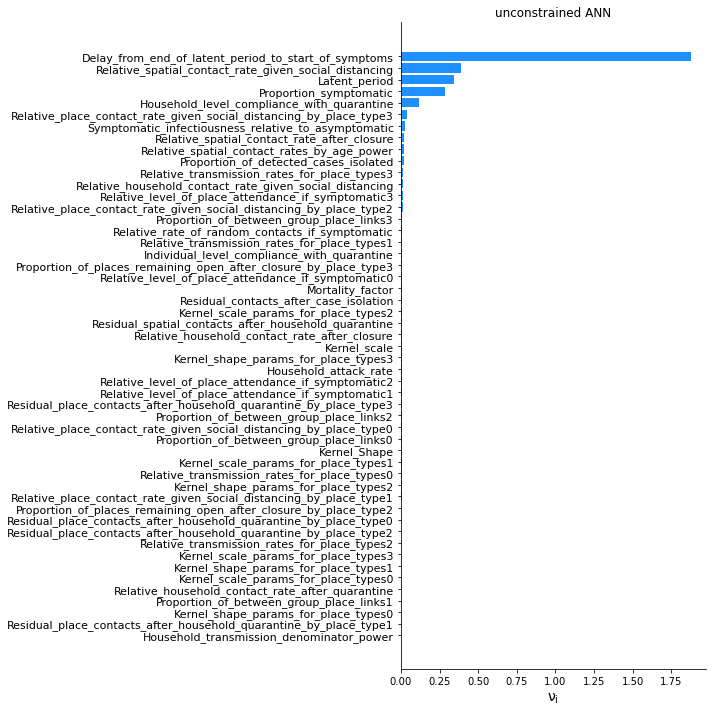

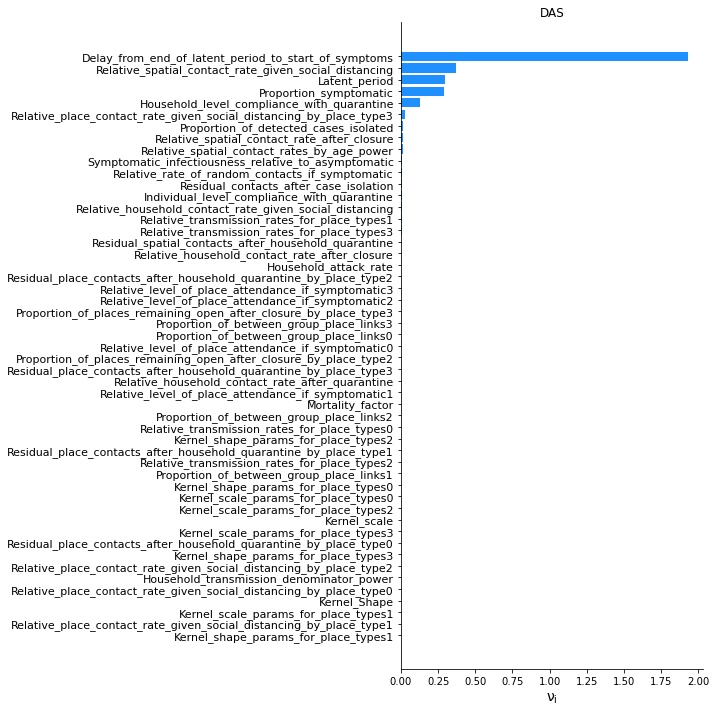

In [15]:
# get the parameter names from the vary dict
param_names = np.array(list(vary.keys()))

# ANN SA
idx, V_i = ann_analysis.sensitivity_measures(params, norm=norm)
sensitivity(idx, V_i, title='unconstrained ANN')

# DAS SA
idx, V_i = das_analysis.sensitivity_measures(params, norm=norm)
sensitivity(idx, V_i, title='DAS')